# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools
import datetime

# Settings

In [3]:
settings = {
    "measure_x": False,
    "blocks": 10,
    "batch_size": 100,
    "epochs": 1000,
    "learning_rate": 1e-3,
    "N": 40,
    "state": {
        "mode": "gkp",
        "delta": 0.325,
        "logical_state": "-z"
    },
    "N_large": 100,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 42,
}


if settings["state"]["mode"] == "gkp":
    delta = settings["state"]["delta"]
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": settings["N"]})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))
    settings["state"]["squeezing_level"] = squeezing_level
    target_state_cavity = gkp_qubit.basis[settings["state"]["logical_state"]]
    title = f"GKP Squeezing level: {squeezing_level:.2f} dB"

elif settings["state"]["mode"] == "fock_1":
    N = 20
    target_state_cavity = jqt.basis(N, 1)
    title = f"Fock state |1> (N={N})"

settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

settings["data_filename"]

'data/20250528_h10m59s47_gkp_state_prep.npz'

### Tests

In [4]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0], [0.0,0.0]])

final_state = run_circuit(
    params, 50
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

NameError: name 'run_circuit' is not defined

# Helpers

In [26]:
def run_circuit(params, N, measure_x=settings["measure_x"]):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    if measure_x:
        cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")

    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()

def fid_metric(params, target_state):
    N = target_state.dims[0][1]
    prepared_state = run_circuit(params, N)
    return jnp.real(jqt.overlap(target_state, prepared_state))

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0, None))

def metric(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

def cf_tomography_circuit(state, beta, measure_real=True):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    
    if measure_real:
        cirq.append(jqtc.Ry(jnp.pi/2), 0)
    else:
        cirq.append(jqtc.Rx(jnp.pi/2), 0)

    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state, betas_re=None, betas_im=None):
    if len(osc_state.dims[0]) == 1:
        if osc_state.is_dm():
            state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
        else:
            state = jqt.basis(2,0) ^ osc_state
    else:
        state = osc_state

    # Plot CF
    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 101)
    betas_im = betas_re if betas_re is not None else  jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=True)))
    tomo_res_real = cf_tomography_circuit_vmap(betas_flat)

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=False)))
    tomo_res_imag = cf_tomography_circuit_vmap(betas_flat)
    
    tomo_res_real = tomo_res_real.reshape(*betas.shape)
    tomo_res_imag = tomo_res_imag.reshape(*betas.shape)

    tomo_res = tomo_res_real + 1j*tomo_res_imag

    return tomo_res, betas_re, betas_im


def calculate_cf(osc_state, betas_re=None, betas_im=None):
    # Plot CF
    N = osc_state.dims[0][0]

    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 41)
    betas_im = betas_im if betas_im is not None else jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in tqdm(range(len(betas_re))):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


In [61]:
best_params = jnp.load(r"C:\Users\EQuS\Github\common\jaxquantum\experiments\circuit\data\20250523_h00m54s43_gkp_state_prep.npz", allow_pickle=True)["best_params"][()]
best_params = jnp.round(best_params, 6)
params_input = {
    "gammas_x": (best_params[0]%1).tolist(),
    "gammas_y": (best_params[1]%1).tolist(),
    "betas_re": best_params[2].tolist(),
    "betas_im": best_params[3].tolist(),
    "final_x_basis_measurement": False,
}
best_params = jnp.array([params_input["gammas_x"], params_input["gammas_y"], params_input["betas_re"], params_input["betas_im"]])

final_state = run_circuit(best_params, 40)

# data=np.load(r"C:\Users\EQuS\Github\common\jaxquantum\experiments\circuit\data\gkp_delta_0p4_20250522.npz", allow_pickle=True)
# optimal_instructions = data["best_params"][()]

# best_params = jnp.array([optimal_instructions["gammas_x"], optimal_instructions["gammas_y"], optimal_instructions["betas_re"], optimal_instructions["betas_im"]])


# final_state = run_circuit(best_params, 40)

In [64]:
final_state = jqt.basis(2,0) ^ jqt.basis(40,0)

In [65]:
betas_re = jnp.linspace(-4, 4, 51)
betas_im = jnp.linspace(-4, 4, 51)

final_state = final_state.ptrace(1)

cf_vals, betas_re, betas_im = calculate_cf(final_state, betas_re, betas_im)

100%|██████████| 51/51 [00:03<00:00, 13.28it/s]


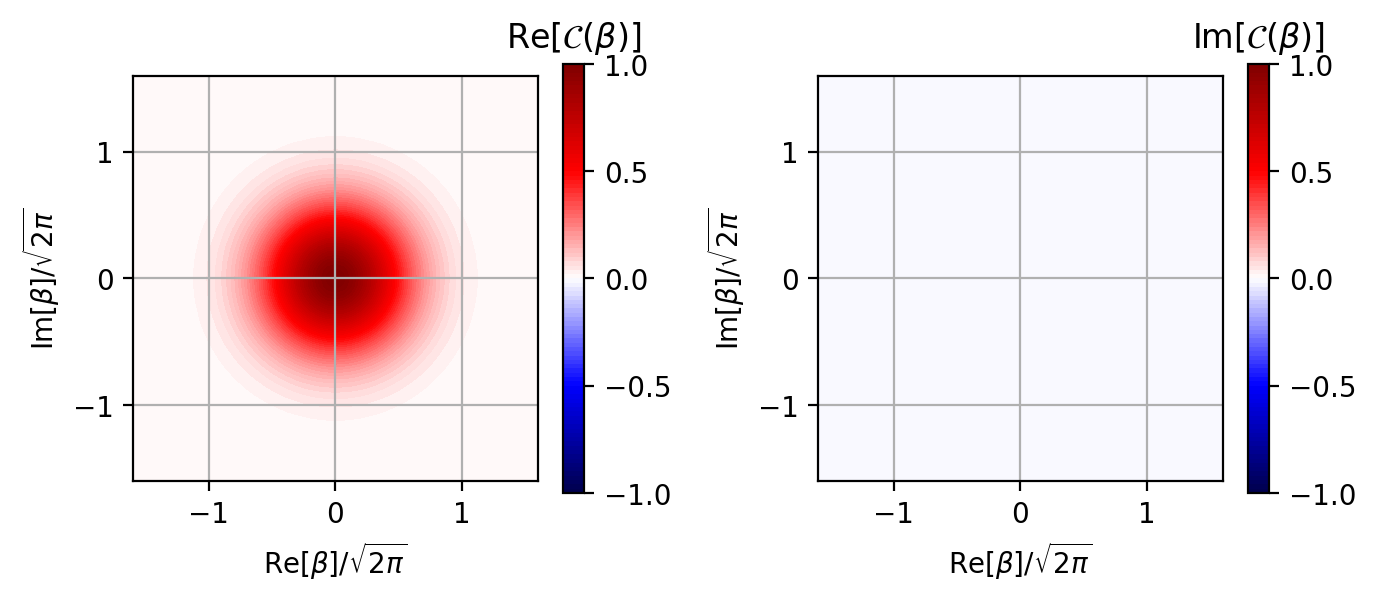

In [67]:
fig, axs = plt.subplots(1,2, figsize=(7, 3), dpi=200)


for j, ax in enumerate(axs):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    # ax.set_title(r"Optimized GKP $|-z\rangle$ " + "\n" + r"with $\Delta = $" + f"{delta:.4f}")
fig.tight_layout()

# Target (set this)

Text(0.5, 1.0, 'GKP Squeezing level: 9.76 dB')

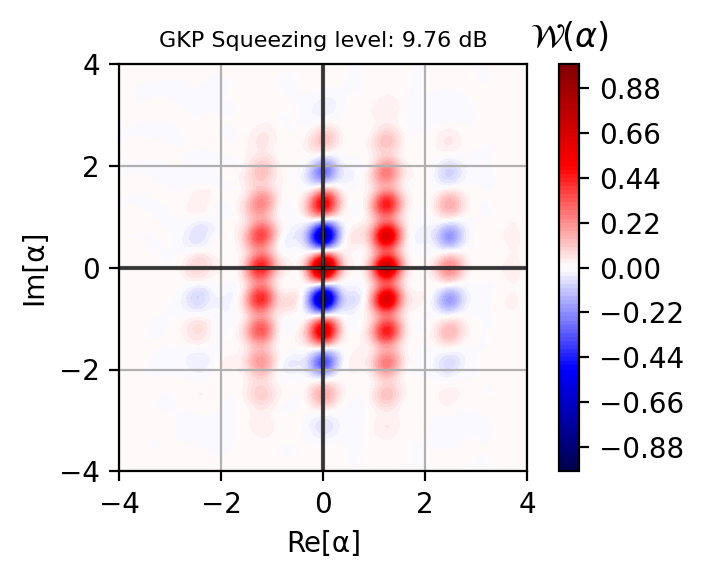

In [5]:
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(settings["target_state_cavity"], pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title(title, fontsize=8)

In [6]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0], [0.0,0.0]])
metric(jnp.array([params,2*params]), settings["target_state"])

NameError: name 'metric' is not defined

# Batch Gradient Descent

In [11]:
# # Option 1: seed with older sweep

data = np.load(r"C:\Users\EQuS\Github\common\jaxquantum\experiments\circuit\data\20250522_h18m53s36_gkp_state_prep.npz", allow_pickle=True)
# settings = data["settings"][()]
history = data["history"][()]
best_params = data["best_params"][()]

random_initial_params = jnp.array([best_params])

# best_params = params_input[()]["best_params"]
# settings = params_input[()]["settings"]

# best_params = jnp.array([params_input["gammas_x"], params_input["gammas_y"], params_input["betas_re"], params_input["betas_im"]])
# best_params = jnp.array([jnp.concatenate([best_params[j], np.array([0,0])]) for j in range(4)])

# import jax

# B = 100
# # Add Gaussian noise to best_params
# key = jax.random.PRNGKey(420)
# noise = jax.random.normal(key, shape=(B,) + best_params.shape) * 0.5  # adjust stddev as needed
# noisy_params = best_params + noise

# lower_bounds = jnp.array([-1, -1, -4, -4])  # Define the lower bounds for each axis
# upper_bounds = jnp.array([1, 1, 4, 4])  # Define the upper bounds for each axis

# # Clip noisy_params by lower_bounds and upper_bounds
# random_initial_params = jnp.clip(noisy_params, lower_bounds[:, None], upper_bounds[:, None])

In [ ]:
# # Option 2: random initialization

# # Parameters
# key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
# B = settings["batch_size"] # Batch size
# num_blocks = settings["blocks"]
# lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
# upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
# random_initial_params = jax.random.uniform(
#     key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
# )

In [14]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

9.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
settings.keys()

dict_keys(['measure_x', 'blocks', 'batch_size', 'epochs', 'learning_rate', 'N', 'state', 'N_large', 'bounds', 'random_seed', 'target_state_cavity', 'target_state', 'data_filename'])

In [16]:
start_learning_rate = settings["learning_rate"]
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = settings["epochs"]
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params, settings["target_state"]))
  metric, grads = metric_val_and_grad(params, settings["target_state"])
  metric_history.append(metric)

  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metric:.4f}, best fid = {jnp.max(fids_history[-1])}")

    fids_history_array = jnp.array(fids_history)
    log_infid_history = jnp.log10(1-fids_history_array)
    best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
    best_fid =fids_history_array[best_fid_epoch_indx, best_fid_batch_indx]

    best_params = params_history[best_fid_epoch_indx][best_fid_batch_indx]
    np.savez(settings["data_filename"], settings=settings, best_params=best_params) # TODO: maybe save fids and parameter histories too?


  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


# Final Save ----

fids_history = jnp.array(fids_history)
params_history = jnp.array(params_history)
metric_history = jnp.array(metric_history)

best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]

np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: metric = -2.1027, best fid = 0.8778716470656993


  1%|▏         | 14/1000 [00:00<01:02, 15.83it/s]

Epoch 10: metric = -2.1053, best fid = 0.878190838182953


  2%|▏         | 21/1000 [00:01<01:10, 13.85it/s]

Epoch 20: metric = -2.1076, best fid = 0.8784646665857881


  3%|▎         | 32/1000 [00:02<01:00, 16.08it/s]

Epoch 30: metric = -2.1094, best fid = 0.878693816253563


  4%|▍         | 44/1000 [00:02<00:57, 16.73it/s]

Epoch 40: metric = -2.1112, best fid = 0.8789091592077365


  5%|▌         | 54/1000 [00:03<00:57, 16.57it/s]

Epoch 50: metric = -2.1130, best fid = 0.8791240013883269


  6%|▌         | 62/1000 [00:03<00:57, 16.20it/s]

Epoch 60: metric = -2.1148, best fid = 0.8793433466138131


  7%|▋         | 74/1000 [00:04<00:55, 16.67it/s]

Epoch 70: metric = -2.1167, best fid = 0.8795687194466789


  8%|▊         | 84/1000 [00:05<00:52, 17.46it/s]

Epoch 80: metric = -2.1186, best fid = 0.8798015452043345


  9%|▉         | 94/1000 [00:05<00:56, 15.95it/s]

Epoch 90: metric = -2.1206, best fid = 0.8800436258233099


 10%|█         | 104/1000 [00:06<00:52, 16.92it/s]

Epoch 100: metric = -2.1227, best fid = 0.8802970958916454


 11%|█▏        | 114/1000 [00:06<00:52, 16.85it/s]

Epoch 110: metric = -2.1250, best fid = 0.8805643087100258


 12%|█▏        | 124/1000 [00:07<00:48, 17.90it/s]

Epoch 120: metric = -2.1274, best fid = 0.8808479051945418


 13%|█▎        | 134/1000 [00:07<00:49, 17.65it/s]

Epoch 130: metric = -2.1299, best fid = 0.8811507051056151


 14%|█▍        | 144/1000 [00:08<00:51, 16.72it/s]

Epoch 140: metric = -2.1326, best fid = 0.881475436815786


 15%|█▌        | 154/1000 [00:09<00:49, 17.20it/s]

Epoch 150: metric = -2.1356, best fid = 0.8818242406441972


 16%|█▌        | 161/1000 [00:09<00:55, 15.22it/s]

Epoch 160: metric = -2.1388, best fid = 0.8821980856662233


 18%|█▊        | 175/1000 [00:10<00:46, 17.91it/s]

Epoch 170: metric = -2.1421, best fid = 0.8825965488988456


 18%|█▊        | 185/1000 [00:10<00:45, 18.09it/s]

Epoch 180: metric = -2.1457, best fid = 0.8830185521160198


 19%|█▉        | 194/1000 [00:11<00:47, 17.05it/s]

Epoch 190: metric = -2.1496, best fid = 0.8834636817140257


 20%|██        | 204/1000 [00:12<00:45, 17.65it/s]

Epoch 200: metric = -2.1536, best fid = 0.8839327990782422


 21%|██▏       | 214/1000 [00:12<00:45, 17.34it/s]

Epoch 210: metric = -2.1579, best fid = 0.8844275069316657


 22%|██▏       | 222/1000 [00:13<00:48, 15.98it/s]

Epoch 220: metric = -2.1624, best fid = 0.8849491018437925


 23%|██▎       | 234/1000 [00:13<00:45, 16.90it/s]

Epoch 230: metric = -2.1672, best fid = 0.8854976872196547


 24%|██▍       | 244/1000 [00:14<00:41, 18.06it/s]

Epoch 240: metric = -2.1722, best fid = 0.8860717507882592


 25%|██▌       | 253/1000 [00:14<00:43, 17.32it/s]

Epoch 250: metric = -2.1774, best fid = 0.886667796511118


 26%|██▋       | 264/1000 [00:15<00:41, 17.81it/s]

Epoch 260: metric = -2.1829, best fid = 0.8872812055214128


 27%|██▋       | 274/1000 [00:16<00:40, 17.98it/s]

Epoch 270: metric = -2.1884, best fid = 0.8879086453325448


 28%|██▊       | 284/1000 [00:16<00:39, 18.17it/s]

Epoch 280: metric = -2.1941, best fid = 0.8885434340735424


 29%|██▉       | 293/1000 [00:17<00:41, 17.21it/s]

Epoch 290: metric = -2.1998, best fid = 0.8891786808539728


 30%|███       | 304/1000 [00:17<00:38, 18.18it/s]

Epoch 300: metric = -2.2055, best fid = 0.8898091267177922


 31%|███▏      | 313/1000 [00:18<00:40, 16.93it/s]

Epoch 310: metric = -2.2112, best fid = 0.890428782400346


 32%|███▏      | 324/1000 [00:18<00:38, 17.68it/s]

Epoch 320: metric = -2.2167, best fid = 0.8910320803656434


 33%|███▎      | 333/1000 [00:19<00:38, 17.14it/s]

Epoch 330: metric = -2.2221, best fid = 0.8916139839111168


 34%|███▍      | 341/1000 [00:19<00:46, 14.16it/s]

Epoch 340: metric = -2.2272, best fid = 0.892170184543399


 35%|███▌      | 354/1000 [00:20<00:37, 17.24it/s]

Epoch 350: metric = -2.2321, best fid = 0.8926972485945791


 36%|███▌      | 361/1000 [00:21<00:43, 14.77it/s]

Epoch 360: metric = -2.2367, best fid = 0.8931926994829317


 37%|███▋      | 373/1000 [00:21<00:37, 16.67it/s]

Epoch 370: metric = -2.2411, best fid = 0.8936548669907033


 38%|███▊      | 381/1000 [00:22<00:40, 15.28it/s]

Epoch 380: metric = -2.2451, best fid = 0.8940826487072175


 39%|███▉      | 393/1000 [00:22<00:36, 16.75it/s]

Epoch 390: metric = -2.2488, best fid = 0.8944781336512647


 40%|████      | 404/1000 [00:23<00:33, 18.04it/s]

Epoch 400: metric = -2.2523, best fid = 0.8948412285405625


 41%|████▏     | 414/1000 [00:24<00:33, 17.35it/s]

Epoch 410: metric = -2.2554, best fid = 0.8951730211694391


 42%|████▏     | 422/1000 [00:24<00:37, 15.41it/s]

Epoch 420: metric = -2.2583, best fid = 0.8954756045512724


 43%|████▎     | 432/1000 [00:25<00:37, 15.19it/s]

Epoch 430: metric = -2.2610, best fid = 0.8957512454808456


 44%|████▍     | 441/1000 [00:25<00:40, 13.96it/s]

Epoch 440: metric = -2.2634, best fid = 0.8960022055091836


 45%|████▍     | 448/1000 [00:26<00:29, 18.78it/s]

Epoch 450: metric = -2.2656, best fid = 0.8962307639836153


 46%|████▋     | 464/1000 [00:27<00:30, 17.44it/s]

Epoch 460: metric = -2.2676, best fid = 0.8964391399412119


 47%|████▋     | 473/1000 [00:27<00:31, 16.73it/s]

Epoch 470: metric = -2.2694, best fid = 0.8966294230931988


 48%|████▊     | 484/1000 [00:28<00:29, 17.21it/s]

Epoch 480: metric = -2.2711, best fid = 0.8968035442595852


 49%|████▉     | 494/1000 [00:28<00:28, 17.80it/s]

Epoch 490: metric = -2.2727, best fid = 0.8969632386252179


 50%|█████     | 503/1000 [00:29<00:30, 16.55it/s]

Epoch 500: metric = -2.2741, best fid = 0.8971099849142589


 51%|█████     | 512/1000 [00:29<00:30, 16.08it/s]

Epoch 510: metric = -2.2754, best fid = 0.8972441065607887


 52%|█████▏    | 524/1000 [00:30<00:27, 17.13it/s]

Epoch 520: metric = -2.2766, best fid = 0.8973695524845969


 53%|█████▎    | 532/1000 [00:30<00:28, 16.43it/s]

Epoch 530: metric = -2.2777, best fid = 0.897484938690379


 54%|█████▍    | 544/1000 [00:31<00:27, 16.66it/s]

Epoch 540: metric = -2.2788, best fid = 0.897591282446948


 55%|█████▌    | 551/1000 [00:32<00:31, 14.10it/s]

Epoch 550: metric = -2.2797, best fid = 0.8976895949684961


 56%|█████▌    | 561/1000 [00:32<00:29, 14.80it/s]

Epoch 560: metric = -2.2806, best fid = 0.8977804150218269


 57%|█████▋    | 571/1000 [00:33<00:28, 14.80it/s]

Epoch 570: metric = -2.2815, best fid = 0.8978640021808921


 58%|█████▊    | 581/1000 [00:33<00:29, 14.34it/s]

Epoch 580: metric = -2.2822, best fid = 0.8979414313421231


 59%|█████▉    | 592/1000 [00:34<00:25, 15.99it/s]

Epoch 590: metric = -2.2829, best fid = 0.8980122926616214


 60%|██████    | 604/1000 [00:35<00:23, 17.08it/s]

Epoch 600: metric = -2.2835, best fid = 0.8980776619139988


 61%|██████    | 611/1000 [00:35<00:27, 14.14it/s]

Epoch 610: metric = -2.2841, best fid = 0.8981375508460355


 62%|██████▏   | 621/1000 [00:36<00:27, 13.88it/s]

Epoch 620: metric = -2.2847, best fid = 0.8981923344528805


 63%|██████▎   | 632/1000 [00:36<00:22, 16.04it/s]

Epoch 630: metric = -2.2852, best fid = 0.8982424189446545


 64%|██████▍   | 641/1000 [00:37<00:25, 14.19it/s]

Epoch 640: metric = -2.2856, best fid = 0.8982881402452384


 65%|██████▌   | 651/1000 [00:38<00:24, 14.49it/s]

Epoch 650: metric = -2.2860, best fid = 0.8983298281883019


 66%|██████▌   | 662/1000 [00:38<00:20, 16.11it/s]

Epoch 660: metric = -2.2864, best fid = 0.8983677800940334


 67%|██████▋   | 671/1000 [00:39<00:23, 13.88it/s]

Epoch 670: metric = -2.2867, best fid = 0.8984020938243354


 68%|██████▊   | 683/1000 [00:39<00:19, 16.55it/s]

Epoch 680: metric = -2.2870, best fid = 0.8984332491694755


 69%|██████▉   | 694/1000 [00:40<00:17, 17.15it/s]

Epoch 690: metric = -2.2873, best fid = 0.8984614899233058


 70%|███████   | 701/1000 [00:41<00:20, 14.36it/s]

Epoch 700: metric = -2.2876, best fid = 0.8984876344848223


 71%|███████   | 711/1000 [00:41<00:19, 15.15it/s]

Epoch 710: metric = -2.2878, best fid = 0.8985109012008119


 72%|███████▏  | 723/1000 [00:42<00:17, 16.05it/s]

Epoch 720: metric = -2.2880, best fid = 0.8985319291062943


 73%|███████▎  | 731/1000 [00:42<00:20, 13.44it/s]

Epoch 730: metric = -2.2882, best fid = 0.8985507940227733


 74%|███████▍  | 741/1000 [00:43<00:18, 13.94it/s]

Epoch 740: metric = -2.2884, best fid = 0.8985672293041436


 75%|███████▌  | 754/1000 [00:44<00:14, 16.69it/s]

Epoch 750: metric = -2.2885, best fid = 0.8985830700513444


 76%|███████▌  | 762/1000 [00:44<00:16, 14.72it/s]

Epoch 760: metric = -2.2887, best fid = 0.8985967409279912


 77%|███████▋  | 772/1000 [00:45<00:15, 15.04it/s]

Epoch 770: metric = -2.2888, best fid = 0.8986090150258621


 78%|███████▊  | 781/1000 [00:45<00:14, 14.67it/s]

Epoch 780: metric = -2.2889, best fid = 0.8986199753457221


 79%|███████▉  | 793/1000 [00:46<00:12, 16.22it/s]

Epoch 790: metric = -2.2890, best fid = 0.8986297827108459


 80%|████████  | 801/1000 [00:46<00:13, 14.57it/s]

Epoch 800: metric = -2.2891, best fid = 0.8986381446578685


 81%|████████  | 811/1000 [00:47<00:13, 14.27it/s]

Epoch 810: metric = -2.2891, best fid = 0.8986461961928728


 82%|████████▏ | 821/1000 [00:48<00:12, 14.84it/s]

Epoch 820: metric = -2.2892, best fid = 0.8986530361096405


 83%|████████▎ | 831/1000 [00:48<00:11, 14.13it/s]

Epoch 830: metric = -2.2893, best fid = 0.8986595596125155


 84%|████████▍ | 841/1000 [00:49<00:11, 13.73it/s]

Epoch 840: metric = -2.2893, best fid = 0.89866515943965


 85%|████████▌ | 852/1000 [00:49<00:09, 14.98it/s]

Epoch 850: metric = -2.2894, best fid = 0.8986700844910637


 86%|████████▌ | 862/1000 [00:50<00:09, 15.30it/s]

Epoch 860: metric = -2.2894, best fid = 0.8986735633373506


 87%|████████▋ | 871/1000 [00:51<00:09, 13.83it/s]

Epoch 870: metric = -2.2895, best fid = 0.8986784091017427


 88%|████████▊ | 881/1000 [00:51<00:08, 13.80it/s]

Epoch 880: metric = -2.2895, best fid = 0.8986821781478669


 89%|████████▉ | 891/1000 [00:52<00:07, 13.85it/s]

Epoch 890: metric = -2.2895, best fid = 0.8986855144026051


 90%|█████████ | 902/1000 [00:53<00:06, 15.35it/s]

Epoch 900: metric = -2.2896, best fid = 0.89868850722268


 91%|█████████ | 911/1000 [00:53<00:06, 13.83it/s]

Epoch 910: metric = -2.2896, best fid = 0.8986911864250263


 92%|█████████▏| 922/1000 [00:54<00:05, 15.19it/s]

Epoch 920: metric = -2.2896, best fid = 0.8986934890509741


 93%|█████████▎| 932/1000 [00:54<00:04, 15.18it/s]

Epoch 930: metric = -2.2896, best fid = 0.8986945178852914


 94%|█████████▍| 941/1000 [00:55<00:04, 12.79it/s]

Epoch 940: metric = -2.2896, best fid = 0.8986973515885865


 95%|█████████▌| 952/1000 [00:56<00:03, 14.93it/s]

Epoch 950: metric = -2.2897, best fid = 0.8986995321746174


 96%|█████████▌| 961/1000 [00:56<00:03, 12.96it/s]

Epoch 960: metric = -2.2897, best fid = 0.8987012993110692


 97%|█████████▋| 971/1000 [00:57<00:02, 13.43it/s]

Epoch 970: metric = -2.2897, best fid = 0.8987027494612267


 98%|█████████▊| 984/1000 [00:58<00:01, 15.60it/s]

Epoch 980: metric = -2.2897, best fid = 0.898702574017918


 99%|█████████▉| 992/1000 [00:58<00:00, 14.17it/s]

Epoch 990: metric = -2.2897, best fid = 0.898704898137923


100%|██████████| 1000/1000 [00:58<00:00, 16.97it/s]


In [17]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\EQuS\AppData\Local\Temp\ipykernel_35072\790125059.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
C:\Users\EQuS\AppData\Local\Temp\ipykernel_35072\790125059.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")


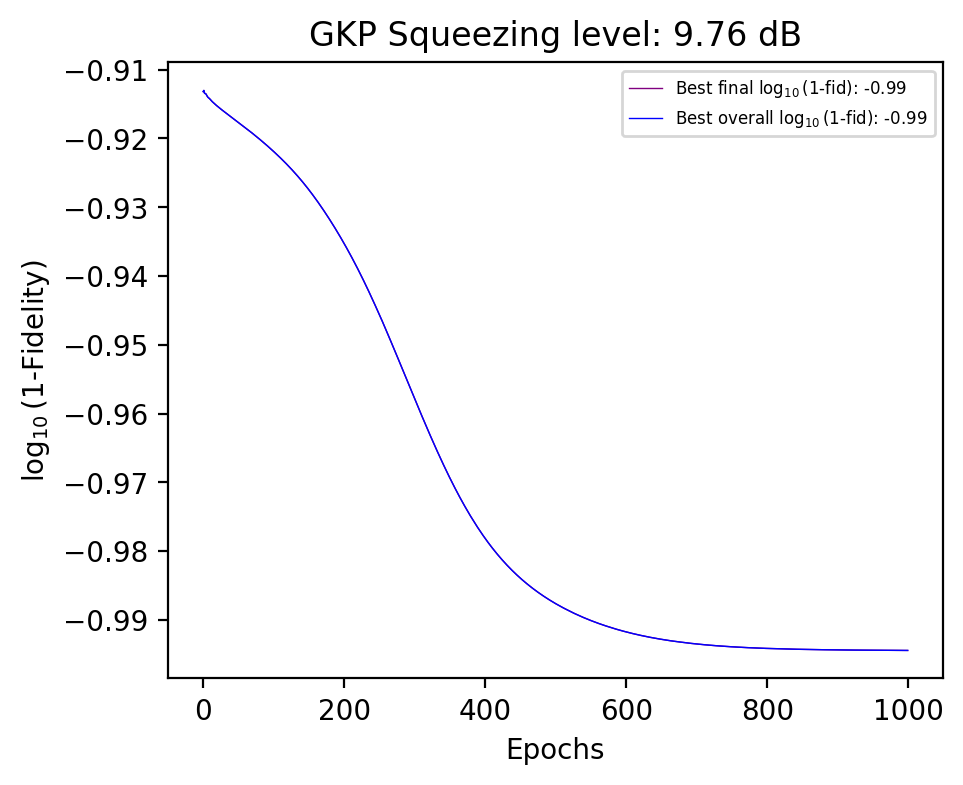

In [18]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(title)
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

# Plotting Optimal

In [17]:
# params_input = {
#     "gammas_x": best_params[0].tolist(),
#     "gammas_y": best_params[1].tolist(),
#     "betas_re": best_params[2].tolist(),
#     "betas_im": best_params[3].tolist(),
#     "final_x_basis_measurement": False,
# }

# for key, value in params_input.items():
#     if isinstance(value, bool):
#         continue
#     params_input[key] = [np.round(v,6) for v in value]

In [ ]:
# params_input = np.load("data/gkp_delta_0p4_20250522.npz", allow_pickle=True)["best_params"][()]
# best_params = jnp.array([params_input["gammas_x"], params_input["gammas_y"], params_input["betas_re"], params_input["betas_im"]])

In [ ]:
# np.savez("data/gkp_delta_0p3_20250522_1707.npz", best_params=params_input)

In [62]:
# best_params = jnp.array([
#     [0.0,0.0,0.5],
#     [0.0,0.0,0.0],
#     [3.0,0.0,3.0],
#     [0.0,3.0,3.0]
# ]
# )

In [ ]:
# data = np.load(r"C:\Users\EQuS\Github\common\jaxquantum\experiments\circuit\data\20250522_h18m01s25_gkp_state_prep.npz", allow_pickle=True)
# best_params = data["best_params"][()]
# settings = data["settings"]

In [9]:
data=np.load(r"C:\Users\EQuS\Github\common\jaxquantum\experiments\circuit\data\gkp_delta_0p4_20250522.npz", allow_pickle=True)
optimal_instructions = data["best_params"][()]

best_params = jnp.array([optimal_instructions["gammas_x"], optimal_instructions["gammas_y"], optimal_instructions["betas_re"], optimal_instructions["betas_im"]])

prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 9.628720e-01  7.417200e-02  2.441000e-03  6.086930e-01  1.404030e-01
   6.363920e-01  4.635650e-01  1.226180e-01  5.280000e-03  2.592810e-01]
 [ 7.859410e-01  7.428910e-01  4.929610e-01  8.069060e-01  3.886970e-01
   9.502230e-01  4.132500e-02  2.486700e-02  9.434680e-01  2.956770e-01]
 [ 2.461055e+00 -3.604788e+00 -3.583444e+00  4.812220e-01 -3.956890e-01
  -3.397558e+00 -2.582452e+00 -2.241945e+00  2.492311e+00 -2.690700e-02]
 [-7.197400e-02  2.378566e+00  1.695645e+00 -2.541334e+00 -1.236023e+00
  -1.411992e+00  1.039990e+00 -1.596640e+00  3.671900e-01  5.233420e-01]]


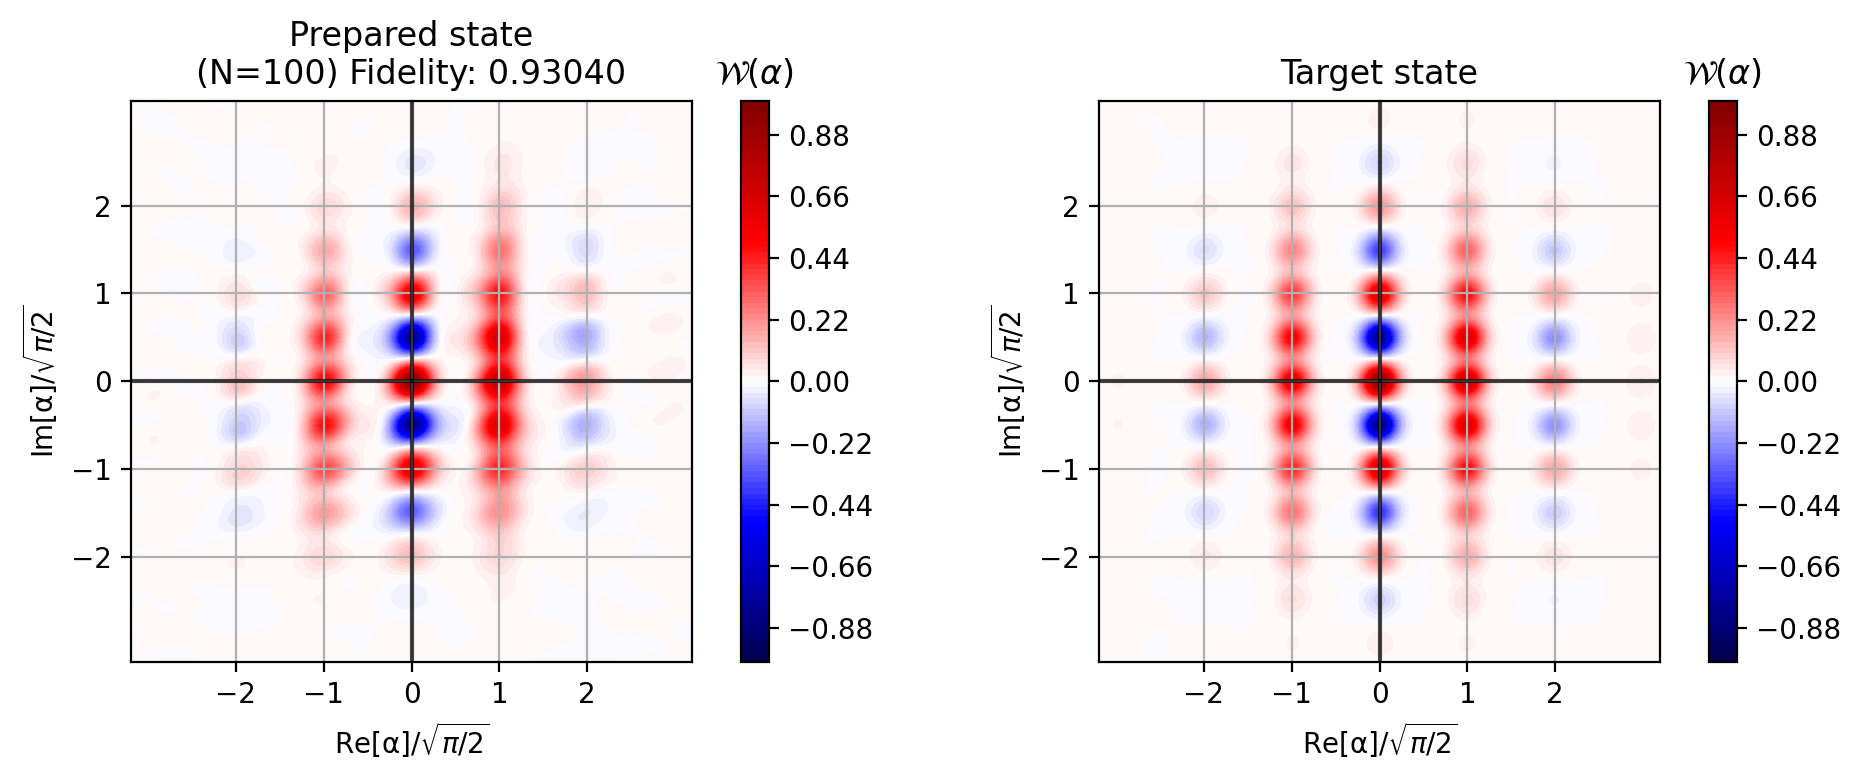

In [31]:
print("Best parameters: \n", best_params)

if settings["state"]["mode"] == "gkp":
    N_large = settings["N_large"]
    gkp_qubit_larger = jqtb.GKPQubit({"delta": settings["state"]["delta"], "N": N_large})
    target_state_larger = jqt.basis(2,0) ^ gkp_qubit_larger.basis[settings["state"]["logical_state"]]
elif settings["state"]["mode"] == "fock_1":
    N_large = settings["N_large"]
    target_state_larger = jqt.basis(2,0) ^ jqt.basis(N, 1) 

fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(prepared_state,1), pts, ax=axs[0], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
# ax.set_title("Prepared state\n" + f"(N=50) Fidelity: {best_fid:.5f}\n" + f"(N={N}) Fidelity: {fid:.5f}")
ax.set_title("Prepared state\n" + f"(N={N_large}) Fidelity: {fid:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger.ptrace(1), pts, ax=axs[1], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
ax.set_title("Target state")

fig.tight_layout()

In [34]:
betas_re = jnp.linspace(-3.2,3.2, 101)
betas_im = jnp.linspace(-3.2,3.2, 101)

cf_vals, _, _ = calculate_cf(settings["target_state"].ptrace(1), betas_re, betas_im)

100%|██████████| 101/101 [00:13<00:00,  7.39it/s]


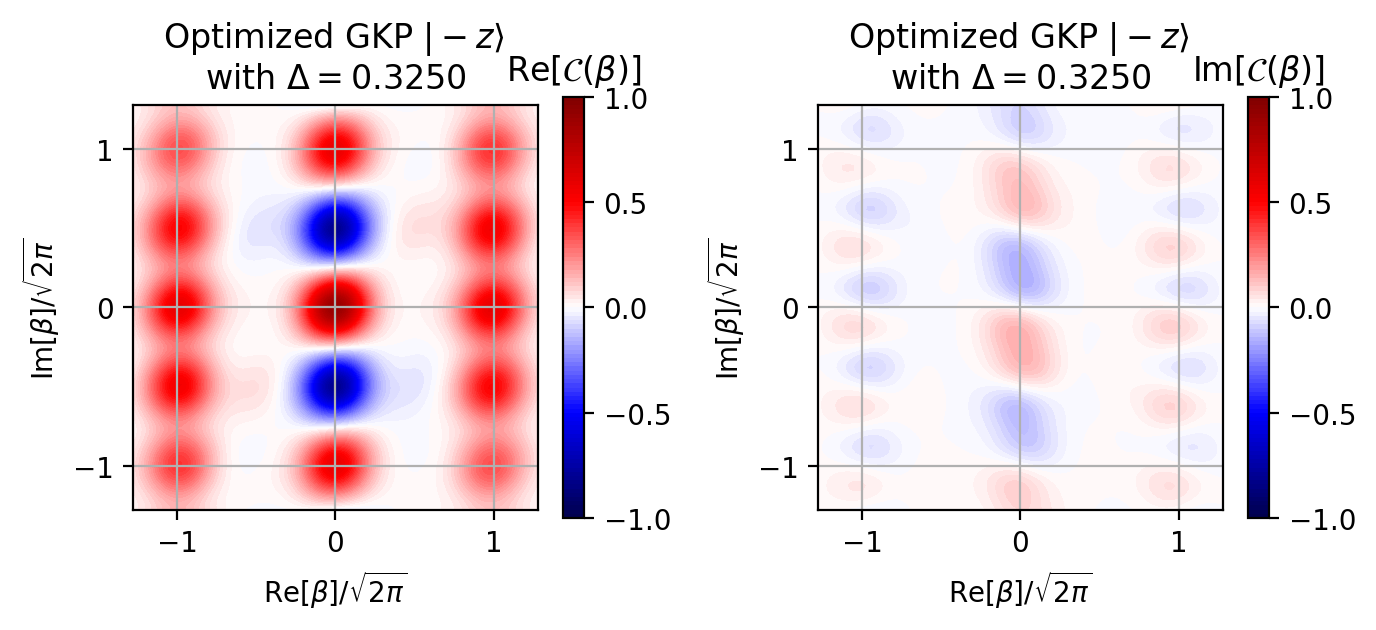

In [35]:
fig, axs = plt.subplots(1,2, figsize=(7, 3), dpi=200)


for j, ax in enumerate(axs):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    ax.set_title(r"Optimized GKP $|-z\rangle$ " + "\n" + r"with $\Delta = $" + f"{delta:.4f}")
fig.tight_layout()

# Debugging

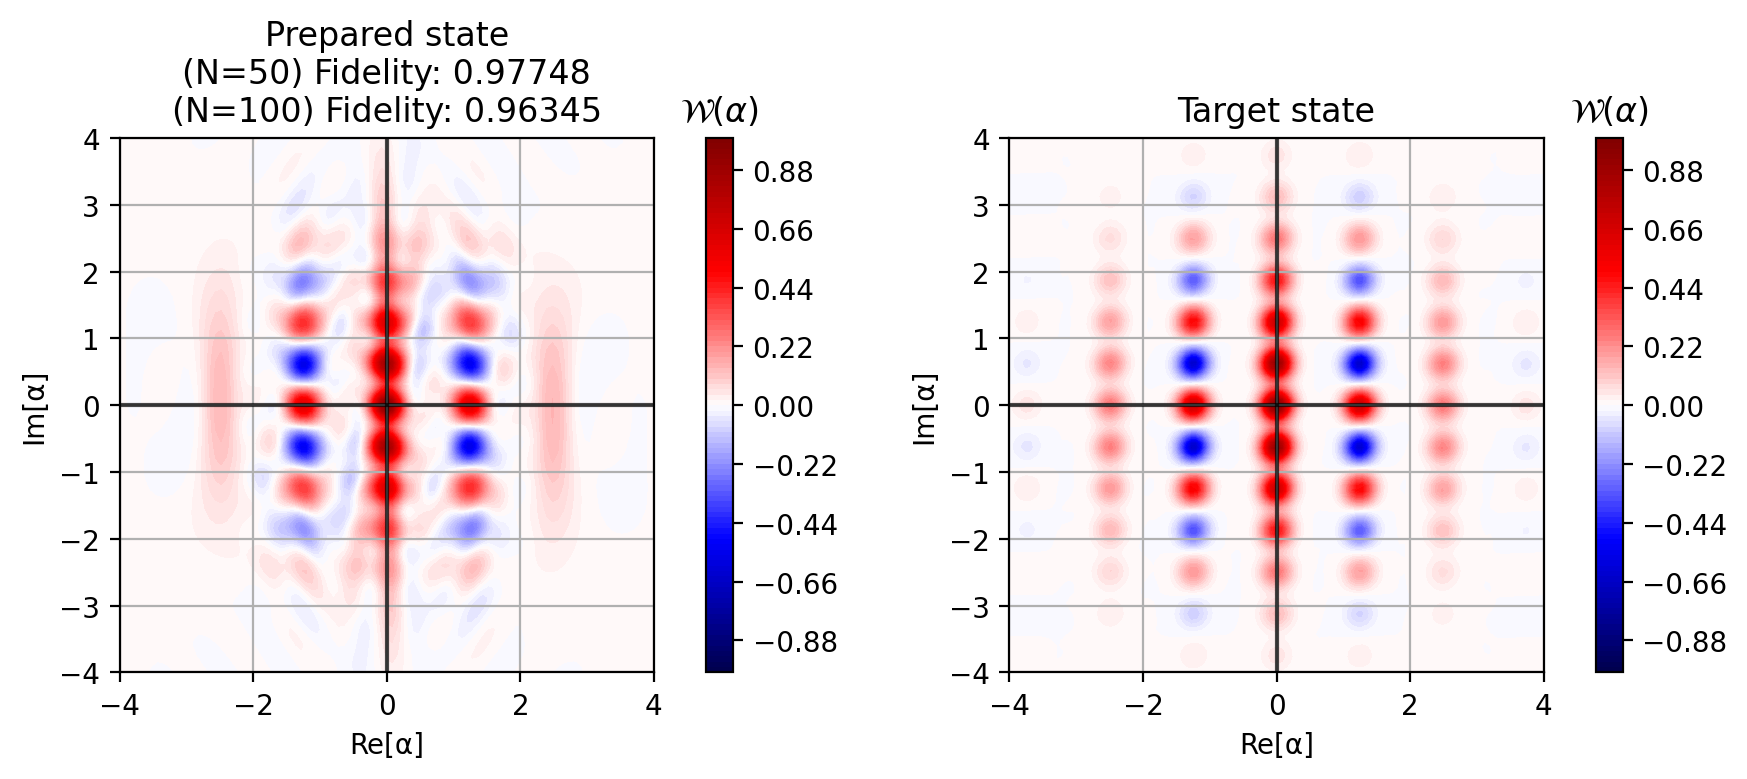

In [127]:
best_params = jnp.array([[ 0.50012385,  0.39523304, -0.3275471 , -0.09874416],
[ 0.2490166 ,  0.50010219,  0.50048423, -0.49811903],
[-2.27944313,  0.12582531, -0.34547531, -2.11939675],
[ 3.28548294, -1.94665808, -1.94882969, -2.94004652]])


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

fids = []
N_list = [50, 100]
for N in N_list:
    delta = 0.3
    gkp_qubit_larger = jqtb.GKPQubit({"delta": delta, "N": N})
    target_state_larger = gkp_qubit_larger.basis["+z"]
    state = run_circuit (best_params[:,:4], N)
    prepared_state = jqt.ptrace(state,1)
    fids.append(jnp.real(jqt.overlap(target_state_larger, prepared_state)))

pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"(N={N_list[0]}) Fidelity: {fids[0]:.5f}\n" + f"(N={N_list[1]}) Fidelity: {fids[1]:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()
fig.tight_layout()

In [128]:
tomo_res, betas_re, betas_im = calculate_cf(prepared_state)
tomo_res_plot = jnp.real(tomo_res)

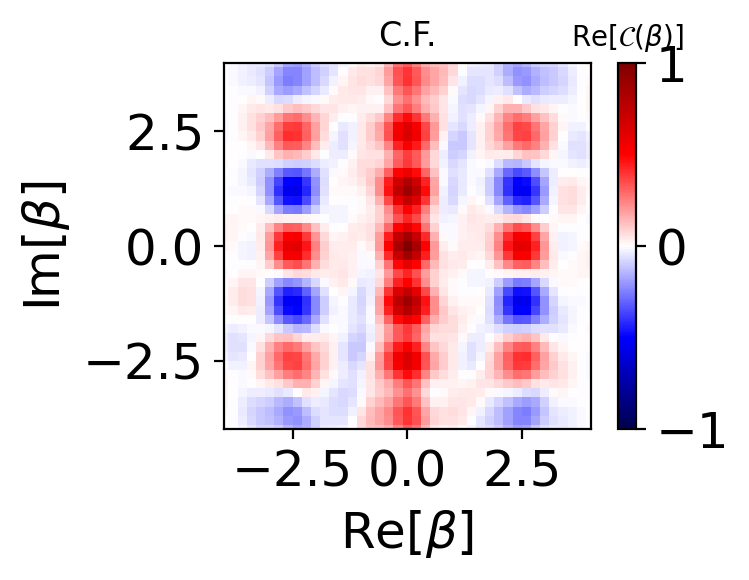

In [129]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.pcolormesh(betas_re, betas_im, tomo_res_plot.T, cmap='seismic', vmax=1, vmin=-1)

ax.set_xlabel(r'Re[$\beta$]', fontsize=18)
ax.set_ylabel(r'Im[$\beta$]', fontsize=18)
# ax.set_xticks([-2,0,2])
# ax.set_yticks([-2,0,2])
lims = [-4,4]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.tick_params(labelsize=18)

ax.set
ax.grid(False)
ax.set_title('C.F.')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_title(r"Re[$\mathcal{C}(\beta)$]", fontsize=10)
# cbar.ax.set_title(r'$\langle \hat{\sigma}_x \rangle$', fontsize=18)
# cbar.ax.set_yticks([-0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=18)

ax.set_aspect('equal')
fig.tight_layout()
